In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import cv2

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data cleaning

The objective of this section is to clearly separate the train and test dataset.

In [8]:
# The images and labels are to be loaded from the following sources
IMG_BASE = '/kaggle/input/covidxct/3A_images/'
LABELS_train = '/kaggle/input/covidxct/train_COVIDx_CT-3A.txt'
LABELS_test = '/kaggle/input/covidxct/test_COVIDx_CT-3A.txt'
SUMMARY = '/kaggle/input/covidxct/metadata.csv'

# Class names, in order of index
CLASSES = ('NORMAL', 'PNEUMONIA', 'COVID-19')

# Checkpoints available at
CHECKPOINT = "CT.keras"

# Define the dimensions of the image
height = 256
width = 256

In [9]:
# The following modules will be employed for pre-processing the training data

def process_row(row):
    fname, cls, xmin, ymin, xmax, ymax = row.strip('\n').split()
    bboxes = (int(xmin), int(ymin), int(xmax), int(ymax))
    
    image = load_img(fname, bboxes)

    return image, cls
    

def load_img(fname, bbox=None):
    """Loads and preprocesses images for inference"""
    image_file = IMG_BASE + fname
    # Load and crop image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    if bbox is not None:
        image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    image = cv2.resize(image, (width, height), cv2.INTER_CUBIC)

    # Convert to float in range [0, 1]
    image = image.astype(np.float32) / 255.0

    # Shift to tensorflow
    image =  tf.image.convert_image_dtype(image, dtype=tf.float32)
    return tf.reshape(image, [height, width, 1])

def find_row_with_string(filename, search_string):
    try:
        with open(filename, 'r') as file:
            for line in file:
                if search_string in line:
                    # The below randomisation is to ensire that the other CT images are also accessed and not just the first one
                    # This is to help increase the amount of training data used
                    if random.random() < 1/5:
                        return line.strip()
                    else:
                        pass
    except FileNotFoundError:
        print("File not found.")

# Data retrieval

In [10]:
df = pd.read_csv(SUMMARY)
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,patient id,source,country,sex,age,finding,verified finding,slice selection,view,modality
0,CP_0,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
1,CP_10,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
2,CP_1068,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
3,CP_1070,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
4,CP_1071,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT


In [11]:
Diagnoses = df['finding'].unique()

# Split the DataFrame based on the 'finding' column
df_covid = df[df['finding'] == 'COVID-19']
df_pneumonia = df[df['finding'] == 'Pneumonia']
df_normal = df[df['finding'] == 'Normal']

data = [df_normal, df_pneumonia, df_covid]

for diag in data:
    print(diag.count())

patient id          649
source              649
country             642
sex                 366
age                 366
finding             649
verified finding    649
slice selection       0
view                649
modality            649
dtype: int64
patient id          932
source              932
country             901
sex                  95
age                  95
finding             932
verified finding    932
slice selection     932
view                932
modality            932
dtype: int64
patient id          4487
source              4487
country             3823
sex                 2516
age                 2487
finding             4487
verified finding    4487
slice selection     4487
view                4487
modality            4487
dtype: int64


In [12]:
def DataProd(n, label_src):
    # n gives the number of samples from each class to be included in the dataset produced

    x_list = []
    y_list = []
    error = 0

    y_i = 0

    for diag in data:
        samp = diag.sample(n) # Randomly sample n elements from the dataset
    
        for index, row in samp.iterrows():
            try:
                img_data = find_row_with_string(label_src, row['patient id'])
                x, y = process_row(img_data)
                x_list.append(x)
                if int(y) == (y_i): # this is to verify that the images are labelled appropriately in the text files
                    y_list.append(int(y))
                else:
                    print("Fatal Data Flaw. Data in text file modified!")
                    print("Classes:", y, y_i)
                    y_list.append(int(y_i))
            except:
                error += 1
                pass

        y_i += 1

    print("The missing rate for images is ", error / ( len(y_list) + error))
    print("The number of images is ", len(y_list))

    indices = random.sample(range(len(x_list)), len(x_list))

    x_list = [x_list[i] for i in indices]
    y_list = [y_list[i] for i in indices]

    return tf.stack(x_list), tf.constant(y_list)

In [13]:
x_list, y_list = DataProd(40, LABELS_train)

Fatal Data Flaw. Data in text file modified!
Classes: 2 1
Fatal Data Flaw. Data in text file modified!
Classes: 2 1
The missing rate for images is  0.43333333333333335
The number of images is  68


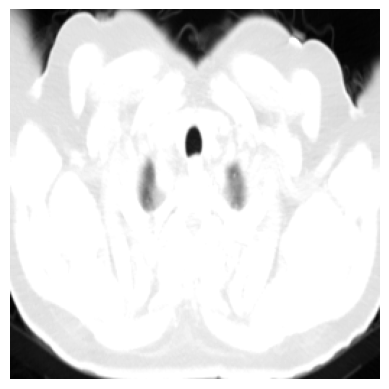

NORMAL


In [16]:
index = 12
# Test what the image looks like
plt.imshow(x_list[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()
print(CLASSES[y_list[index]])

# Model Building

In [18]:
model = tf.keras.Sequential()

model.add(layers.Input(shape=(height, width, 1)))

# Convolution layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# Output layer with 3 neurons (for classification into 3 classes)
model.add(layers.Dense(3, activation='softmax'))  # Use softmax for multi-class classification

learning_rate = 0.0005 # Define the learning rate for the neural network

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['mean_squared_error', 'accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,878,467 (64.39 MB)

 Trainable params: 16,878,467 (64.39 MB)

 Non-trainable params: 0 (0.00 B)

In [274]:
num_batches = 10
batch_size = 50 # The actual size of batch will be approximately batch_size * 3 * 0.7
epochs = 15
training_runs = 100

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT,
                                                 verbose=1,
                                                 monitor="val_accuracy",
                                                 save_best_only=True,
                                                 mode="max",)

In [ ]:
for i in range(training_runs):
    x_list, y_list = DataProd(num_batches * batch_size, LABELS_train)
    y_list = tf.one_hot(y_list, 3).numpy()
    
    history = model.fit(
        x_list,
        y_list,
        batch_size=batch_size,
        epochs=5,
        validation_split=0.1,
        callbacks=[cp_callback],
    ) 
    
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'], color='red')
    plt.ylim(0, 1)

In [21]:
# There is a bit of overfitting that needs to be addressed

In [68]:
def PredictType(image):
    # This function returns the class of the image in terms of its position in CLASSES
    pred = model.predict(tf.reshape(x_list[3], (1, x_list[3].shape[0], x_list[3].shape[1], x_list[3].shape[2]) ))
    return tf.math.argmax(pred[0])

# Model testing

In [ ]:
def GetMetrics(x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = (y_pred > 0.5).astype('int32')
    y_pred_classes = [np.argmax(y_pred_classes[i]) for i in range(len(y_pred_classes))]
    y_pred_classes = np.array(y_pred_classes)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=CLASSES)
    
    # Print metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUC: {auc}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    disp.plot()
    plt.show()

Fatal Data Flaw. Data in text file modified!
Classes: 2 1
Fatal Data Flaw. Data in text file modified!
Classes: 0 2
The missing rate for images is  0.8433333333333334
The number of images is  94
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 826ms/step
Accuracy: 0.8723404255319149
Precision: 0.8784981226533166
Recall: 0.8723404255319149
AUC: 0.9308367816770261
Confusion Matrix:
[[48  2  0]
 [ 1 22  6]
 [ 2  1 12]]


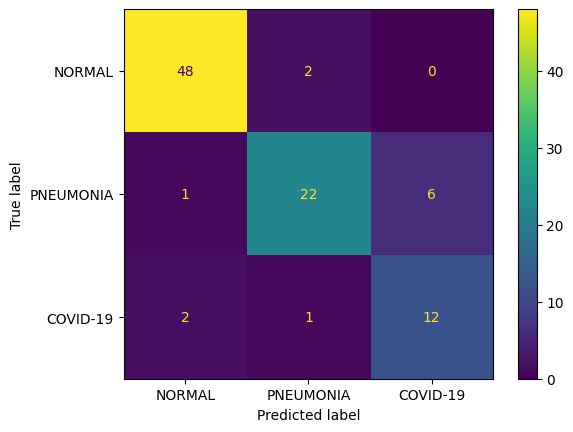

In [308]:
# Get the test data first of all
x_test, y_test = DataProd(200, LABELS_test)

# Calculate the metrics
GetMetrics(x_test, y_test)

# Segmentation model

## Create masked images

In [277]:
num_box = 16

def ImageMaskGenerator(image):
    """
    Takes a 256x256x1 grayscale image and returns 256 images,
    each with one distinct num_box x num_box box filled with its average pixel value.
    
    Args:
        image (tf.Tensor): A 256x256x1 grayscale image.

    Returns:
        List[tf.Tensor]: List of 256 images with averaged boxes.
    """
    if image.shape != (256, 256, 1):
        raise ValueError("Input image must have shape (256, 256, 1)")

    images_with_averaged_boxes = []

    # Create 16x16 boxes
    for row in range(num_box):
        for col in range(num_box):
            # Create a copy of the image
            modified_image = tf.identity(image)

            # Calculate the start and end indices for the box
            start_row, end_row = row * num_box, (row + 1) * num_box
            start_col, end_col = col * num_box, (col + 1) * num_box

            # Calculate the average pixel value in the box
            box = image[start_row:end_row, start_col:end_col, 0]
            avg_value = tf.reduce_mean(box)

            # Fill the box with the average value
            modified_image = tf.tensor_scatter_nd_update(
                modified_image,
                indices=tf.constant(
                    [[r, c, 0] for r in range(start_row, end_row) for c in range(start_col, end_col)],
                    dtype=tf.int32
                ),
                updates=tf.fill([num_box * num_box], avg_value)
            )

            images_with_averaged_boxes.append(modified_image)

    return tf.stack(images_with_averaged_boxes)

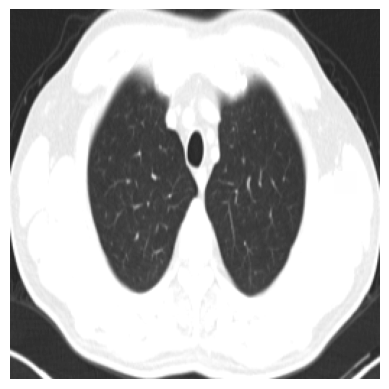

NORMAL


In [278]:
index = 126
i_data = 1
MImg = ImageMaskGenerator(x_list[i_data])
# Test what the image looks like
plt.imshow(MImg[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()
print(CLASSES[tf.argmax(y_list[i_data])])

## Feed images in NN and see deviation

In [279]:
def GetRef(image):
    pred = model.predict(tf.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]) ))
    ref = tf.math.reduce_max(pred)
    return ref

def normalize_and_reshape(tensor: tf.Tensor) -> tf.Tensor:
    """
    Normalizes a TensorFlow tensor of length num_box*num_box to [0, 1] and reshapes to num_box x num_box.

    Args:
        tensor (tf.Tensor): A TensorFlow tensor of length num_box * num_box.

    Returns:
        tf.Tensor: A 16x16 TensorFlow image.
    """
    if tensor.shape != (num_box * num_box,):
        raise ValueError("Input tensor must have shape (num_box * num_box,)")

    # Normalize the tensor to [0, 1]
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val + 1e-7)

    # Reshape the tensor into a 16x16 image
    image = tf.reshape(normalized_tensor, (num_box, num_box, 1))

    return tf.image.resize(image, (256, 256) ,method="mitchellcubic")

In [300]:
img_segment = x_list[3]

MImg = ImageMaskGenerator(img_segment)
res = model.predict(MImg)
ref = GetRef(img_segment)
cls = int(PredictType(img_segment))

print(f"This image is of type {CLASSES[cls]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
This image is of type COVID-19


In [301]:
mask_probs = []

for r in res:
    if r[cls] < ref:
        mask_probs.append(ref - r[cls])
    else:
        mask_probs.append(0)

mask_probs = tf.stack(mask_probs)

In [302]:
res[0][2]

0.99994

In [303]:
masks = normalize_and_reshape(mask_probs)

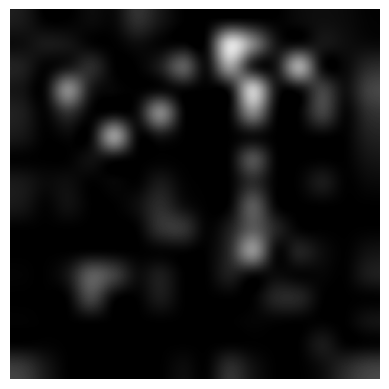

In [304]:
# Visualise the effects the different masks have on the image
plt.imshow(masks, cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

In [305]:
def overlay_red_highlight(base_image: tf.Tensor, overlay_image: tf.Tensor) -> tf.Tensor:
    """
    Overlays a red highlight on a grayscale image using a second grayscale image.

    Args:
        base_image (tf.Tensor): A 256x256x1 grayscale image.
        overlay_image (tf.Tensor): A 256x256x1 grayscale image.

    Returns:
        tf.Tensor: A 256x256x3 RGB image with red highlights.
    """
    if base_image.shape != (256, 256, 1) or overlay_image.shape != (256, 256, 1):
        raise ValueError("Both images must have shape (256, 256, 1)")

    # Normalize overlay image to [0, 1]
    min_val = tf.reduce_min(overlay_image)
    max_val = tf.reduce_max(overlay_image)
    normalized_overlay = (overlay_image - min_val) / (max_val - min_val + 1e-7)

    # Create RGB channels
    red_channel = base_image + normalized_overlay
    green_channel = base_image
    blue_channel = base_image

    # Concatenate to get an RGB image
    rgb_image = tf.concat([red_channel, green_channel, blue_channel], axis=-1)

    return rgb_image

In [306]:
segmented_img = overlay_red_highlight(img_segment, masks)

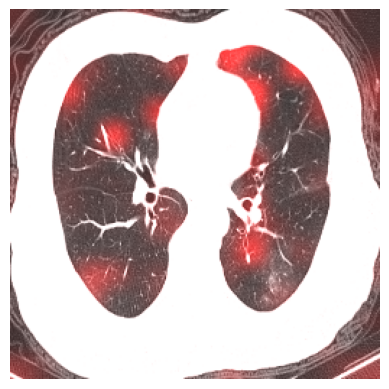

The red highlighted segments show the regions that indicate that the image corresponds to COVID-19.


In [307]:
# Visualise the effects the different masks have on the image
plt.imshow(segmented_img, vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

# If the entire image is red-tinted, then it is a strong indication that the classification is incorrect.

print(f"The red highlighted segments show the regions that indicate that the image corresponds to {CLASSES[cls]}.")